# Simulate overfocused data

This notebook generates a file `fourdstem_overfocused.npy` with a dataset that coarsely simulates the pinhole camera projection in strongly over- or underfocused 4D STEM. Underfocused data is generated if the specified overfocus is negative.

This dataset can then be used to test the interactive adjustment routine in the `stem_overfocus.ipynb` notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba

from libertem.analysis import com as com_analysis

## Set parameters for simulation

The interactive adjustment should then reach equivalent parameters.

In [2]:
size = 64

sim_params = {
    'overfocus': 0.001,  # m
    'scan_pixel_size': 0.000001,  # m
    'camera_length': 0.15,  # m
    'detector_pixel_size': 0.000050,  # m
    'scan_rotation': 37,
    'flip_y': False,
}

## Generate a test object

This is a comic-like face with low symmetry to make it easy for humans to identify the orientation.

In [3]:
obj = np.ones((size, size), dtype=np.complex64)
y, x = np.ogrid[-size//2:size//2, -size//2:size//2]

outline = (((y*1.2)**2 + x**2) > (110/256*size)**2) & ((((y*1.2)**2 + x**2) < (120/256*size)**2))
obj[outline] = 0.0

left_eye = ((y + 40/256*size)**2 + (x + 40/256*size)**2) < (20/256*size)**2
obj[left_eye] = 0
right_eye = (np.abs(y + 40/256*size) < 15/256*size) & (np.abs(x - 40/256*size) < 30/256*size)
obj[right_eye] = 0

nose = (y + 20/256*size + x > 0) & (x < 0) & (y < 10/256*size)

obj[nose] = (0.05j * x + 0.05j * y)[nose]

mouth = (((y*1)**2 + x**2) > (50/256*size)**2) & ((((y*1)**2 + x**2) < (70/256*size)**2)) & (y > 20/256*size)

obj[mouth] = 0

tongue = (((y - 50/256*size)**2 + (x - 50/256*size)**2) < (20/256*size)**2) & ((y**2 + x**2) > (70/256*size)**2)
obj[tongue] = 0

# This wave modulation introduces a strong signature in the diffraction pattern
# that allows to confirm the correct scale and orientation.
signature_wave = np.exp(1j*(3 * y + 7 * x) * 2*np.pi/size)

obj += 0.3*signature_wave - 0.3

obj = np.abs(obj)

## Show the test object

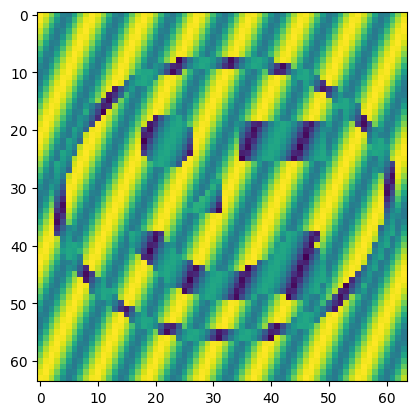

In [4]:
fig, axes = plt.subplots()
axes.imshow(obj)

## Manual ray tracing implementation

This implements a simple model to trace the rays from the pixels of a supposed detector through the object to the supposed focus point above or below the specimen as a function of scan position. Each simulated detector pixel is set to the value of the pixel where the ray passes closest.

In [5]:
detector_shape = (size, size)
sim_params['cy'] = detector_shape[0] / 2
sim_params['cx'] = detector_shape[1] / 2


def get_transformation_matrix(sim_params):
    transformation_matrix = np.array(com_analysis.apply_correction(
        y_centers=np.array((1, 0)),
        x_centers=np.array((0, 1)),
        scan_rotation=sim_params['scan_rotation'],
        flip_y=sim_params['flip_y'],
    ))
    return transformation_matrix

@numba.njit(inline='always', cache=True)
def detector_px_to_specimen_px(y_px, x_px, cy, cx, detector_pixel_size, scan_pixel_size, camera_length, overfocus, transformation_matrix, fov_size_y, fov_size_x):
    position_y, position_x = (y_px - cy) * detector_pixel_size, (x_px - cx) * detector_pixel_size
    position_y, position_x = transformation_matrix @ np.array((position_y, position_x))
    specimen_position_y = position_y / camera_length * overfocus
    specimen_position_x = position_x / camera_length * overfocus
    specimen_px_x = specimen_position_x / scan_pixel_size + fov_size_y / 2
    specimen_px_y = specimen_position_y / scan_pixel_size + fov_size_x / 2
    return int(specimen_px_y), int(specimen_px_x)

In [6]:
@numba.njit(cache=True)
def _project(image, cy, cx, detector_pixel_size, scan_pixel_size, camera_length, overfocus, transformation_matrix, result_out):
    scan_shape = result_out.shape[:2]
    for det_y in range(result_out.shape[2]):
        for det_x in range(result_out.shape[3]):
            specimen_px_y, specimen_px_x = detector_px_to_specimen_px(
                y_px=det_y,
                x_px=det_x,
                cy=cy,
                cx=cx,
                detector_pixel_size=detector_pixel_size,
                scan_pixel_size=scan_pixel_size,
                camera_length=camera_length,
                overfocus=overfocus,
                transformation_matrix=transformation_matrix,
                fov_size_y=image.shape[0],
                fov_size_x=image.shape[1],
                
            )
            for scan_y in range(scan_shape[0]):
                for scan_x in range(scan_shape[1]):
                    offset_y = scan_y - scan_shape[0] // 2
                    offset_x = scan_x - scan_shape[1] // 2
                    image_px_y = specimen_px_y + offset_y
                    image_px_x = specimen_px_x + offset_x
                    if image_px_y < 0 or image_px_y >= image.shape[0]:
                        continue
                    if image_px_x < 0 or image_px_x >= image.shape[1]:
                        continue
                    result_out[scan_y, scan_x, det_y, det_x] = image[image_px_y, image_px_x]

def project(image, scan_shape, detector_shape, sim_params):
    result = np.zeros(tuple(scan_shape) + tuple(detector_shape), dtype=image.dtype)
    _project(
        image=image,
        cy=sim_params['cy'],
        cx=sim_params['cx'],
        detector_pixel_size=sim_params['detector_pixel_size'],
        scan_pixel_size=sim_params['scan_pixel_size'],
        camera_length=sim_params['camera_length'],
        overfocus=sim_params['overfocus'],
        transformation_matrix=get_transformation_matrix(sim_params),
        result_out=result
    )
    return result

## Perform the projection

In [7]:
fourdstem_overfocused = project(obj, detector_shape=detector_shape, scan_shape=(size, size), sim_params=sim_params)

## Show a single simulated detector frame at the center of the scan

Note how this is a magnified and rotated image containing the "nose".

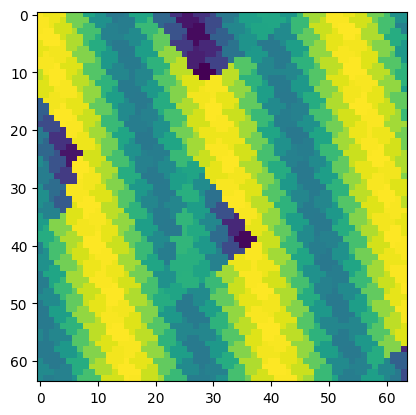

In [8]:
fig, axes = plt.subplots()
axes.imshow(fourdstem_overfocused[size//2, size//2, :, :])

## Show the trace of the central detector pixel

This plots the value of the pixel at the center of the simulated detector as a function of scan position. This reproduces the simulated object.

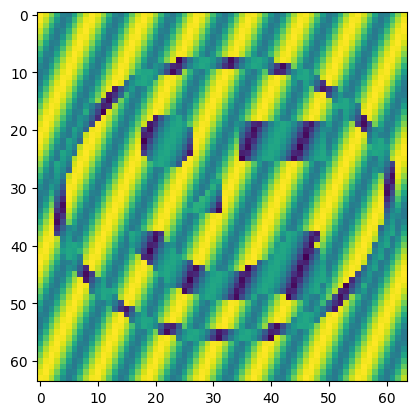

In [9]:
fig, axes = plt.subplots()
axes.imshow(fourdstem_overfocused[:, :, size//2, size//2])

## Save to disk

This file can then be opened in the `stem_overfocus.ipynb` notebook.

In [10]:
np.save("fourdstem_overfocused.npy", fourdstem_overfocused)